<div style="font-size:30px; font-family:verdana; color:#159364">
Demo Notebook for tf-kera-vis
</div>

# References
- https://keisen.github.io/tf-keras-vis-docs/index.html

In [1]:
!pip install tf-keras-vis tensorflow

# Import libraries

In [15]:
import numpy as np
import pprint
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.layercam import Layercam

In [3]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [27]:
names = [l.name for l in model.layers]
pprint.pprint(names, compact=True)

['input_2', 'Conv1_pad', 'Conv1', 'bn_Conv1', 'Conv1_relu',
 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu', 'expanded_conv_project',
 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN',
 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise',
 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project',
 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN',
 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN',
 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN',
 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu',
 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN',
 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN',
 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu',
 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu',
 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand',
 'block_5_

In [10]:
# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()

In [26]:
class_indexes = tf.keras.applications.mobilenet_v2.decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)
for class_info in class_indexes[0]:
    if class_info[1] == 'menu':
        print(class_info[2])

922


In [27]:
class_index = 922
score = CategoricalScore([class_index])

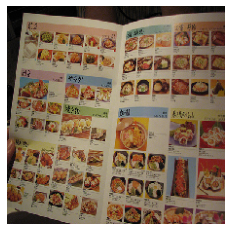

In [28]:

# Load images and Convert them to a Numpy array
img = load_img('./imagenet-sample-images/n07565083_menu.JPEG', target_size=(224, 224))
img = np.asarray(img)

# Preparing input data for VGG16
X = preprocess_input(img)
X = X[tf.newaxis, ...]
plt.axis('off')
plt.imshow(img)

In [29]:
predict = model.predict(X)
result = tf.keras.applications.mobilenet_v2.decode_predictions(predict, top=5)
pprint.pprint(result)

[[('n07565083', 'menu', 0.36379358),
  ('n06596364', 'comic_book', 0.26942727),
  ('n03871628', 'packet', 0.06777264),
  ('n03887697', 'paper_towel', 0.054153986),
  ('n04462240', 'toyshop', 0.02116294)]]


In [30]:
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
gradcam_pp = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
scorecam = Scorecam(model)
layercam = Layercam(model, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
target_layer_index = -2
heatmap_gradcam = gradcam(score, X, penultimate_layer=target_layer_index)
heatmap_gradcam_pp = gradcam_pp(score, X, penultimate_layer=target_layer_index)
heatmap_scorecam = scorecam(score, X, penultimate_layer=target_layer_index)
heatmap_layercam = layercam(score, X, penultimate_layer=target_layer_index)

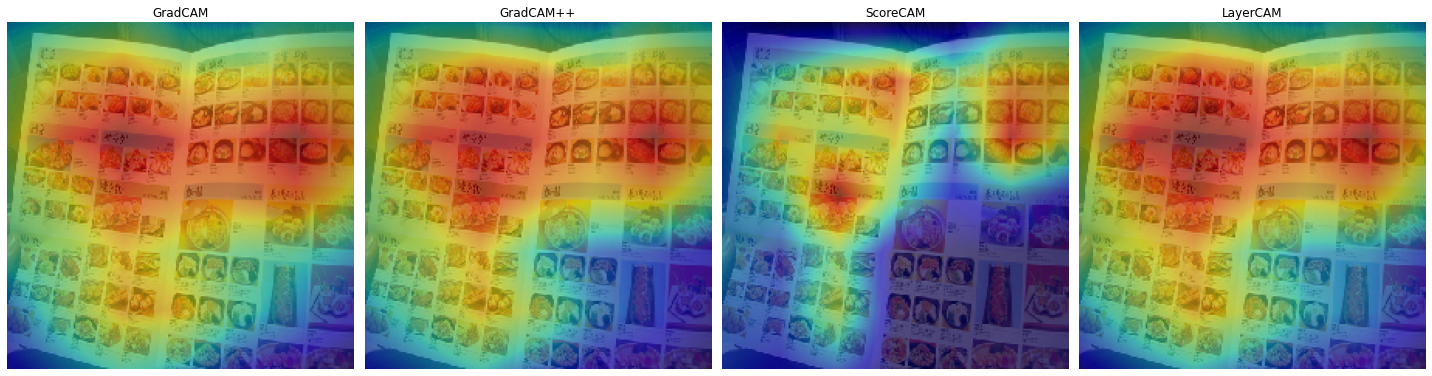

In [31]:
cams = {
    'GradCAM': heatmap_gradcam,
    'GradCAM++': heatmap_gradcam_pp,
    'ScoreCAM': heatmap_scorecam,
    'LayerCAM': heatmap_layercam
}

fig, axes = plt.subplots(1, len(cams), figsize=(20, 10))
for i, (cam_name, cam) in enumerate(cams.items()):
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axes[i].imshow(img)
    axes[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    axes[i].set_title(cam_name)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

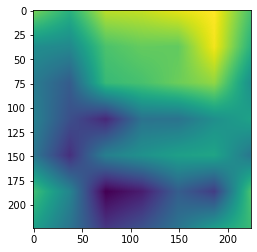

In [43]:
plt.imshow(heatmap_gradcam[0] - heatmap_layercam[0])

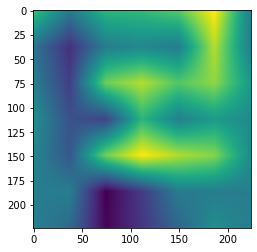

In [44]:
plt.imshow(heatmap_gradcam[0] - heatmap_gradcam_pp[0])

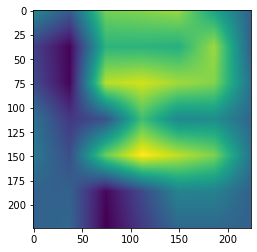

In [45]:
plt.imshow(heatmap_gradcam[0] - heatmap_scorecam[0])